In [1]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import pywt
import matplotlib.pyplot as plt
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

In [2]:
filenames = []
filenames = glob.glob('../data/Maize images/data/Blight/*') + glob.glob('../data/Maize images/data/Gray_Leaf_Spot/*') + glob.glob('../data/Maize images/data/Common_Rust/*') + glob.glob('../data/Maize images/data/Healthy/*')

df = pd.DataFrame(filenames)
df.to_csv('filenames.csv', index=False)

In [3]:
CLASS_NAMES = os.listdir('../data/Maize images/data')
image_data = pd.read_csv('./filenames.csv')
imagelabel = [CLASS_NAMES[0]]*1146 +[CLASS_NAMES[1]]*574 + [CLASS_NAMES[2]]*1306 + [CLASS_NAMES[3]]*1162

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
encoder = LabelEncoder()

def load_image(filename):
    with Image.open(filename) as image:
        return np.asarray(image)

def load_data():
    X = []
    for filename in filenames:
        X.append(load_image(filename=filename))

    LE_imagelabel = encoder.fit_transform(imagelabel)
    np_imagelabel = np.array(LE_imagelabel)
    enc_imagelabel = np.zeros((np_imagelabel.size, np_imagelabel.max() + 1))
    enc_imagelabel[np.arange(np_imagelabel.size), np_imagelabel] = 1
    
    
    X_train, X_test ,y_train, y_test = train_test_split(X, enc_imagelabel, test_size=0.2, random_state=42)
    return (X_train, y_train), (X_test, y_test)

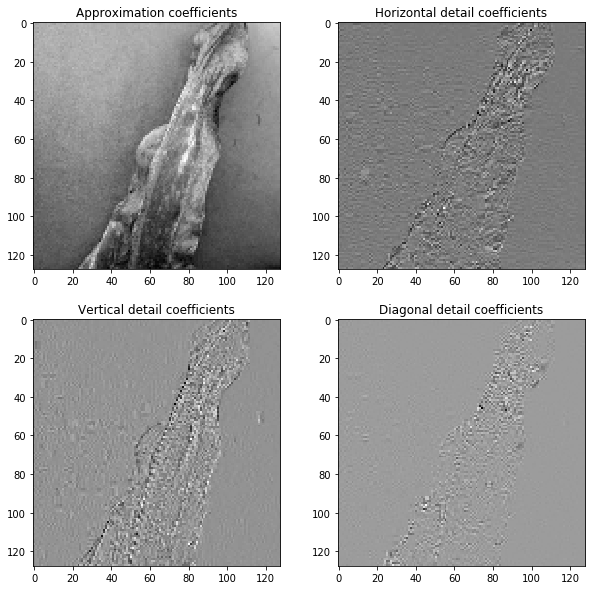

In [5]:
arr = load_image(f'../data/Maize images/data/Blight/Corn_Blight (170).JPG')
cA, (cH, cV, cD) = pywt.dwt2(np.mean(arr, axis=2), "haar")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax[0, 0].imshow(cA, cmap='gray')
ax[0, 0].set_title("Approximation coefficients")
ax[0, 1].imshow(cH, cmap='gray')
ax[0, 1].set_title("Horizontal detail coefficients")
ax[1, 0].imshow(cV, cmap='gray')
ax[1, 0].set_title("Vertical detail coefficients")
ax[1, 1].imshow(cD, cmap='gray')
ax[1, 1].set_title("Diagonal detail coefficients")
plt.show()


In [9]:
(X_train, y_train), (X_test, y_test) = load_data()

X_train_dwt, X_test_dwt = [], []

In [ ]:
def extract_features(X, X_dwt=[]):
    #cA, (cH, cV, cD) -> Approximation, Horizontal Detail, Vertical Detail, Diagonal Detail
    #np.mean converts the rgb image to gray scale
    for image in X:
        cA, (cH, cV, cD) = pywt.dwt2(np.mean(image, axis=2), "haar")
        features = []
        #using mean helps with the overall image structure and intensity while the 
        #std provides info on the local variability and texture of the image
        features.append(np.mean(cA))
        features.append(np.std(cA))
        features.append(np.mean(cH))
        features.append(np.std(cH))
        features.append(np.mean(cV))
        features.append(np.std(cV))
        features.append(np.mean(cD))
        features.append(np.std(cD))
        X_dwt.append(features)
    return X_dwt

X_train_dwt = extract_features(X_train, X_train_dwt)
X_test_dwt = extract_features(X_test, X_test_dwt)


In [ ]:
X_train_dwt_norm = scalar.fit_transform(X_train_dwt)
X_test_dwt_norm = scalar.fit_transform(X_test_dwt)

In [ ]:
import pickle
with open('X_train_dwt', 'wb') as fp:
    pickle.dump(X_train_dwt, fp)

with open('X_test_dwt', 'wb') as fp:
    pickle.dump(X_test_dwt, fp)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score

KNC = KNeighborsClassifier()
KNC.fit(X_train_dwt_norm, y_train)

y_preds = KNC.predict(X_test_dwt_norm)

print('Accuracy: ', accuracy_score(y_test, y_preds))
print('Precision: ', precision_score(y_test, y_preds, pos_label='positive', average='micro'))


In [ ]:
svc = SVC()
svc.fit(X_train_dwt_norm, y_train)
y_pred = svc.predict(X_test_dwt_norm)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, pos_label='positive', average='micro'))

In [ ]:
import xgboost
npX_train_dwt = np.array(X_train_dwt_norm)
npX_test_dwt = np.array(X_test_dwt_norm)
npy_train, npy_test = np.array(y_train), np.array(y_test)

In [ ]:
print(npX_test_dwt[:3])

In [ ]:
xg = xgboost.XGBClassifier()
xg.fit(npX_train_dwt, y_train)
y_predicted = xg.predict(npX_test_dwt)

print('Accuracy: ', accuracy_score(y_test, y_predicted))
print('Precision: ', precision_score(y_test, y_predicted, pos_label='positive', average='micro'))

In [ ]:
type(npX_test_dwt[0])

In [ ]:
from keras.losses import CategoricalCrossentropy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

# Initialising the CNN
model =Sequential([
    Dense(64, activation='relu', input_shape=(8,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='softmax'),
])

model.compile(optimizer='adam', loss=CategoricalCrossentropy(from_logits=True), metrics=['acc'])

hist = model.fit(npX_train_dwt, y_train, epochs=100)

model.evaluate(npX_test_dwt, y_test)[1]

